# Buidling the Knowledge Graph and performing Community Detection

In [ ]:
#Uncomment to install workbook requirements
#!pip install -r requirements.txt
#!pip install en_core_sci_sm-0.5.1.tar.gz

In [1]:
import igraph
import csv
import scispacy
import spacy

## Designing a knowledge graph schema

In [2]:

with open('./data/20k_abstracts_clean.csv', 'r') as c:
	reader = csv.reader(c)
	data = [line for line in reader]


In [3]:
nlp = spacy.load("en_core_sci_sm")

/home/adimn/opt/tinygraph/.venv/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [4]:
text = data[0][1]
doc = nlp(text)
print(list(doc.ents))

[IgE, sensitization, Aspergillus fumigatus, positive sputum, fungal, culture result, patients, refractory asthma, patients, antifungal, treatment, voriconazole, asthma-related, outcomes, patients, asthma, IgE, sensitized, fumigatus, Asthmatic, patients, IgE, sensitized, fumigatus, history, severe, exacerbations, months, treated, months, voriconazole, observation, months, double-blind, placebo-controlled, randomized design, Primary outcomes, improvement, quality of life, treatment, reduction, severe, exacerbations, months, study, Sixty-five, patients, randomized, patients, started, treatment, voriconazole, placebo, intention-to-treat analysis, patients, months, medication, voriconazole, placebo, groups, severe, exacerbations, patient, per year, mean difference, CI, quality of life, Asthma Quality of Life Questionnaire, groups, CI, secondary outcome, months, treatment, voriconazole, patients, moderate-to-severe asthma, IgE, sensitized, rate, severe, exacerbations, quality of life, marker

In [5]:
abstract_entities = [[row[0], nlp(row[1]).ents] for row in data]

In [6]:
abstract_entities = [[row[0], [str(ent).lower() for ent in row[1]]] for row in abstract_entities]
print(abstract_entities[:5])

[['0', ['ige', 'sensitization', 'aspergillus fumigatus', 'positive sputum', 'fungal', 'culture result', 'patients', 'refractory asthma', 'patients', 'antifungal', 'treatment', 'voriconazole', 'asthma-related', 'outcomes', 'patients', 'asthma', 'ige', 'sensitized', 'fumigatus', 'asthmatic', 'patients', 'ige', 'sensitized', 'fumigatus', 'history', 'severe', 'exacerbations', 'months', 'treated', 'months', 'voriconazole', 'observation', 'months', 'double-blind', 'placebo-controlled', 'randomized design', 'primary outcomes', 'improvement', 'quality of life', 'treatment', 'reduction', 'severe', 'exacerbations', 'months', 'study', 'sixty-five', 'patients', 'randomized', 'patients', 'started', 'treatment', 'voriconazole', 'placebo', 'intention-to-treat analysis', 'patients', 'months', 'medication', 'voriconazole', 'placebo', 'groups', 'severe', 'exacerbations', 'patient', 'per year', 'mean difference', 'ci', 'quality of life', 'asthma quality of life questionnaire', 'groups', 'ci', 'secondary 

In [7]:
all_entities = [row[1] for row in abstract_entities]

In [8]:
import itertools
entities = itertools.chain.from_iterable(all_entities)

In [9]:
from collections import Counter
entity_freq = dict(Counter(entities))
entity_freq = dict(sorted(entity_freq.items(), key=lambda item: item[1], reverse=True))
print(entity_freq)

{'patients': 6814, 'group': 2079, 'treatment': 1931, 'study': 1894, 'groups': 1719, 'months': 1424, 'ci': 1314, 'placebo': 1238, 'baseline': 1190, 'randomized': 1134, 'weeks': 1059, 'compared': 981, 'participants': 962, 'years': 905, 'days': 859, 'intervention': 844, 'associated with': 844, 'control group': 765, 'increased': 752, 'efficacy': 727, 'women': 686, 'age': 595, 'assessed': 591, 'follow-up': 586, 'children': 570, 'effect': 555, 'effective': 528, 'data': 527, 'subjects': 525, 'week': 525, 'results': 481, 'risk': 473, 'safety': 467, 'day': 450, 'levels': 437, 'increase': 430, 'evaluate': 413, 'patient': 410, 'measured': 400, 'rate': 395, 'effects': 384, 'improvement': 379, 'reduced': 369, 'reduction': 367, 'decreased': 367, 'outcomes': 362, 'period': 362, 'incidence': 361, 'evaluated': 341, 'changes': 338, 'trial': 329, 'daily': 323, 'adverse events': 309, 'median': 302, 'level': 298, 'dose': 297, 'symptoms': 296, 'surgery': 293, 'rates': 292, 'confidence interval': 288, 'pain'

In [10]:
high_freq = {ent: value for ent, value in entity_freq.items() if value > 100}
print(len(high_freq))
print(len(entity_freq))

209
46487


In [11]:
low_freq = {ent: value for ent, value in entity_freq.items() if value == 1}
print(len(low_freq))

28411


In [12]:
removed_terms = [ent for ent, value in entity_freq.items() if value > 100 or value == 1]

In [13]:
abstract_entities = [[row[0], [ent for ent in row[1] if ent not in removed_terms]]
                  	for row in abstract_entities]
print(abstract_entities[0])

['0', ['ige', 'sensitization', 'voriconazole', 'asthma-related', 'asthma', 'ige', 'sensitized', 'fumigatus', 'asthmatic', 'ige', 'sensitized', 'fumigatus', 'history', 'exacerbations', 'voriconazole', 'observation', 'placebo-controlled', 'randomized design', 'primary outcomes', 'exacerbations', 'started', 'voriconazole', 'intention-to-treat analysis', 'medication', 'voriconazole', 'exacerbations', 'per year', 'mean difference', 'asthma quality of life questionnaire', 'secondary outcome', 'voriconazole', 'ige', 'sensitized', 'exacerbations', 'markers', 'asthma control']]


## Constructing the knowledge graph

In [14]:
terms = [abstract[1] for abstract in abstract_entities]  # get just ents no abstract IDs
unique_terms = list(set(itertools.chain.from_iterable(terms)))

In [15]:
term_ids = {term: i for i, term in enumerate(unique_terms, len(data))}

In [16]:
print(term_ids['ige'])

15849


In [17]:
edgelist = []
for abstract_id, terms in abstract_entities:
    term_freq = dict(Counter(terms))
    for term, freq in term_freq.items():
        edgelist.append([int(term_ids[term]), int(abstract_id), freq])
 
print(edgelist[:10])
assert [term_ids['ige'], 0, 4] in edgelist


[[15849, 0, 4], [9494, 0, 1], [20100, 0, 5], [17408, 0, 1], [4696, 0, 1], [16767, 0, 3], [18406, 0, 2], [13868, 0, 1], [15341, 0, 1], [11215, 0, 4]]


In [18]:
g = igraph.Graph(directed=True)

In [19]:
g.add_vertices(len(term_ids) + len(data))

In [20]:
text = [abstract[1] for abstract in data] + [ent for ent, _ in term_ids.items()]
g.vs['text'] = text

In [21]:
print(g.vs[term_ids['ige']]['text'])

ige


In [22]:
types = ['abstract' for _ in data] + ['term' for _ in term_ids.items()]
g.vs['type'] = types

In [23]:
print(g.vs[term_ids['ige']]['type'])

term


In [27]:
edges = [[source, target] for source, target, _ in edgelist]
frequencies = [freq for _, _, freq in edgelist]
frequencies[:10]

[4, 1, 5, 1, 1, 3, 2, 1, 1, 4]

In [25]:
g.add_edges(edges)
g.es['frequency'] = frequencies

# Knowledge graph analysis and community detection

## Examing knowledge graph structure

In [28]:
print(len(g.vs))
print(len(g.es))

20366
72904


In [29]:
connected_components = g.clusters(mode='weak')
print(connected_components)

Clustering with 20366 elements and 1 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
    75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
    93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
    109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
    124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
    139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
    154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
    169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
    184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
    199, 200, 201, 20

/tmp/ipykernel_22474/754880443.py:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  connected_components = g.clusters(mode='weak')


In [30]:
abstract_nodes = g.vs.select(type_eq='abstract')
term_nodes = g.vs.select(type_eq='term')

In [31]:
abstract_degree = g.degree(abstract_nodes)
term_degree = g.degree(term_nodes)

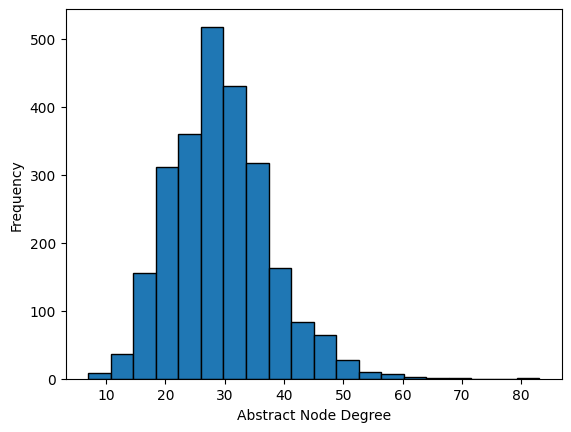

In [32]:
import matplotlib.pyplot as plt
plt.hist(abstract_degree, bins=20, edgecolor='black')
plt.xlabel('Abstract Node Degree')
plt.ylabel('Frequency')
plt.savefig('charts/abstract_degree.jpg')

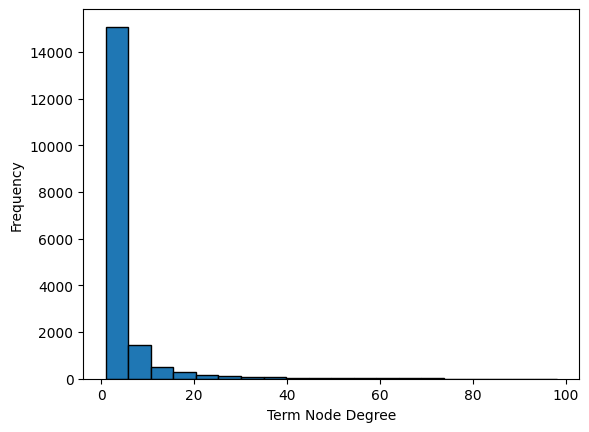

In [33]:
plt.hist(term_degree, bins=20, edgecolor='black')
plt.xlabel('Term Node Degree')
plt.ylabel('Frequency')
plt.savefig('charts/term_node_degree.jpg')

## Identifying abstracts of interest

In [34]:
yoga_node_id = g.vs.select(text_eq='yoga')[0].index
yoga_abstract_nodes = g.neighbors(g.vs[yoga_node_id])
yoga_abstracts = [g.vs[neighbor]['text'] for neighbor in yoga_abstract_nodes]
print(yoga_abstracts)

[" Menopause is the stage when the menstrual period permanently stops , and is a part of every woman 's life . It usually occurs between the ages of 40 and 60 years , and is associated with hormonal , physical , and psychological changes . Estrogen and progesterone levels play the biggest part in menopause . In this stage , the ovaries make less estrogen and progesterone . When the body produces less of these hormones , the parts of the body that depend on estrogen to keep them healthy will react and this often causes discomfort for women . This study tested the impact of a complementary health approach to quality of life in menopausal women . A community-based interventional study was conducted in selected areas in Kattankulathur Block , Kanchipuram District , Tamil Nadu , India . A simple random sampling technique was used to select menopausal women for the study . Of 260 menopausal women identified , 130 were allocated to a study group and 130 to a control group . The study group un

In [35]:
related_term_nodes = [g.neighbors(node) for node in yoga_abstract_nodes]
import itertools
related_term_nodes = set(itertools.chain.from_iterable(related_term_nodes))
related_terms = g.vs(related_term_nodes)['text']
print(related_terms)

['good reliability', 'diagnostic', 'sppb', 'comparing', 'height', 'global improvement', 'stiffness', 'format', 'neck', 'response rates', 'completion', 'time-points', 'stretching group', 'cati', 'investigators', 'environmental domains', 'hormones', 'womac pain', 'options', 'physical function', 'mindfulness', 'low back pain', '6weeks', 'progesterone', 'trial registration', 'triglycerides', '24-week', 'psychological', 'universities', 'ptsd', 'aims', 'western ontario and mcmaster universities osteoarthritis index', 'surveys', 'standing', 'standardized', 'visceral fat', 'rehabilitation', 'prevents', 'randomized trial', 'time points', 'self-administered', 'favorable changes', 'ovaries', 'chronic stroke', 'mental health', 'passive', 'disabilities', 'suppression', 'bonferroni correction', 'oa', 'function', 'difference', 'estrogen', 'pittsburgh sleep quality index', 'fasting', 'menopausal', 'therapeutic-yoga', 'upper', 'fasting glucose', 'endurance', 'liberation', 'engaging', 'san diego', 'sitt

In [36]:
print(len(related_terms))

174


## Identifying fields with Community Detection

In [37]:
g_u = g.as_undirected()

In [38]:
community_membership = g_u.community_multilevel()
print(len(community_membership))

23


In [39]:
for i, community in enumerate(community_membership):
	size = len(community)
	print(f'Community: {i}, size: {size}')

Community: 0, size: 388
Community: 1, size: 2322
Community: 2, size: 439
Community: 3, size: 3731
Community: 4, size: 1230
Community: 5, size: 218
Community: 6, size: 2299
Community: 7, size: 311
Community: 8, size: 1665
Community: 9, size: 1746
Community: 10, size: 201
Community: 11, size: 1974
Community: 12, size: 149
Community: 13, size: 499
Community: 14, size: 679
Community: 15, size: 352
Community: 16, size: 136
Community: 17, size: 634
Community: 18, size: 283
Community: 19, size: 219
Community: 20, size: 194
Community: 21, size: 586
Community: 22, size: 111


In [40]:
smallest_community = sorted(list(community_membership), key=len)[0]
print(smallest_community)

[201, 370, 409, 421, 466, 971, 1156, 1418, 1424, 1452, 1454, 1489, 1838, 2310, 2504, 2797, 2799, 3016, 3816, 3859, 4296, 4886, 5227, 5240, 5243, 5289, 5633, 5872, 5879, 7236, 7301, 7780, 7990, 8090, 8434, 8448, 8471, 8574, 8664, 8845, 9276, 9283, 9287, 9496, 9519, 9676, 9983, 10238, 10273, 10423, 10429, 10606, 10739, 10800, 10980, 11023, 11270, 11325, 11444, 11448, 11594, 11610, 11810, 11972, 11981, 12082, 12105, 12206, 12460, 12773, 12787, 12900, 12996, 13144, 13186, 13323, 13446, 13496, 13639, 13810, 13982, 13986, 14114, 14664, 14832, 15221, 15336, 15362, 15441, 15546, 15682, 15799, 15953, 16237, 16572, 16636, 16977, 17307, 17357, 17402, 17573, 17940, 18035, 18325, 18617, 18679, 19587, 19596, 19697, 20036, 20058]


In [41]:
community_nodes = g.vs[smallest_community].select(type_eq='term')

In [48]:
community_terms = community_nodes['text']
print(community_terms)

['relationships', 'graft function', 'chp', 'donor-specific', 'type of anesthesia', 'probing pocket', 'transplant', 'gingival index', 'cd8 ( + )', 'rtr', 'chronic periodontitis', '638-nm laser', 'clinical attachment', 'apdt', 'cni', 'prevotella intermedia', 'cd38', 'subgingival species', 'spkts', 'resource utilization', 'lvad', 'bregs', 'periodontitis', 'rtrs', 'csa', 'cyclosporine', 'mpcs', 'nonsurgical', 'alem', 'il-10-producing b cells', 'patient death', 'type 2 diabetic subjects', 'cd24', 'root', '4th quartile', 'pmns', 'probing', 'ui', 'estimated glomerular filtration rate', 'rabbit', 'vitale study', 'immunosuppressive therapy', 'graft loss', 'ventricular function', 'renal allograft', 'adjunctive', 'mpc', 'pockets', 'th17a', 'acute rejection', 'periodontal therapy', 'chlorhexidine', 'thrombosis', 'periodontal status', 'ratg', 'recipients', 'clinical attachment gain', 'clinical attachment loss', 'belatacept', 'wean', 'darbepoetin alfa', 'srp', 'renal graft loss', 'th22 cell', 'amx',

## Code from this section

In [1]:
%%writefile build_know_graph.py
""" 
Name:       build_know_graph.py.py
Author(s):  Gary Hutson & Matt Jackson on behalf of Packt publishing
Date:       03/02/2022
Usage:      build_know_graph.py
"""
import igraph
import csv
import scispacy
import spacy
import itertools
from collections import Counter
import matplotlib.pyplot as plt

# Load in data
with open('./data/20k_abstracts_clean.csv', 'r') as c:
	reader = csv.reader(c)
	data = [line for line in reader]

# Load in spacy NLP library
nlp = spacy.load("en_core_sci_sm")
text = data[0][1]
doc = nlp(text)
print(list(doc.ents))

# Get abstract entities 
abstract_entities = [[row[0], nlp(row[1]).ents] for row in data]
abstract_entities = [[row[0], [str(ent).lower() for ent in row[1]]] for row in abstract_entities]
print(abstract_entities[:5])

# Get all entities
all_entities = [row[1] for row in abstract_entities]

# Use itertools to get all entities
entities = itertools.chain.from_iterable(all_entities)

# Get frequency counts using Counter()
entity_freq = dict(Counter(entities))
entity_freq = dict(sorted(entity_freq.items(), key=lambda item: item[1], reverse=True))
print(entity_freq)

high_freq = {ent: value for ent, value in entity_freq.items() if value > 100}
print(len(high_freq))
print(len(entity_freq))

low_freq = {ent: value for ent, value in entity_freq.items() if value == 1}
print(len(low_freq))

# Remove some terms
removed_terms = [ent for ent, value in entity_freq.items() if value > 100 or value == 1]
abstract_entities = [[row[0], [ent for ent in row[1] if ent not in removed_terms]]
                  	for row in abstract_entities]
print(abstract_entities[0])

# Constructing the knowledge graph
terms = [abstract[1] for abstract in abstract_entities]  # get just ents no abstract IDs
unique_terms = list(set(itertools.chain.from_iterable(terms)))


term_ids = {term: i for i, term in enumerate(unique_terms, len(data))}
print(term_ids['ige'])

# Create the edgelists
edgelist = []
for abstract_id, terms in abstract_entities:
    term_freq = dict(Counter(terms))
    for term, freq in term_freq.items():
        edgelist.append([int(term_ids[term]), int(abstract_id), freq])
 
print(edgelist[:10])
assert [term_ids['ige'], 0, 4] in edgelist

# Instantiate igraph as a directed graph
g = igraph.Graph(directed=True)
# Add verticies
g.add_vertices(len(term_ids) + len(data))
# Extract text
text = [abstract[1] for abstract in data] + [ent for ent, _ in term_ids.items()]
g.vs['text'] = text
print(g.vs[term_ids['ige']]['text'])
types = ['abstract' for _ in data] + ['term' for _ in term_ids.items()]
g.vs['type'] = types
print(g.vs[term_ids['ige']]['type'])
edges = [[source, target] for source, target, _ in edgelist]
frequencies = [freq for _, _, freq in edgelist]
g.add_edges(edges)
g.es['frequency'] = frequencies
# Analyze and apply community detection
print(len(g.vs))
print(len(g.es))
# Find weakly connected components
connected_components = g.clusters(mode='weak')
print(connected_components)
# Get the abstract and term nodes
abstract_nodes = g.vs.select(type_eq='abstract')
term_nodes = g.vs.select(type_eq='term')
# Get the degrees
abstract_degree = g.degree(abstract_nodes)
term_degree = g.degree(term_nodes)

# Do some plotting
# Abstract degree first
plt.hist(abstract_degree, bins=20, edgecolor='black')
plt.xlabel('Abstract Node Degree')
plt.ylabel('Frequency')
plt.savefig('charts/abstract_degree.jpg')
plt.show()

# Term degree second
plt.hist(term_degree, bins=20, edgecolor='black')
plt.xlabel('Term Node Degree')
plt.ylabel('Frequency')
plt.savefig('charts/term_node_degree.jpg')

# Identify abstracts of interest
yoga_node_id = g.vs.select(text_eq='yoga')[0].index
yoga_abstract_nodes = g.neighbors(g.vs[yoga_node_id])
yoga_abstracts = [g.vs[neighbor]['text'] for neighbor in yoga_abstract_nodes]
print(yoga_abstracts)

related_term_nodes = [g.neighbors(node) for node in yoga_abstract_nodes]
import itertools
related_term_nodes = set(itertools.chain.from_iterable(related_term_nodes))
related_terms = g.vs(related_term_nodes)['text']
print(related_terms)
print(len(related_terms))

# Identifying fields with Community Detection
g_u = g.as_undirected()
community_membership = g_u.community_multilevel()
print(len(community_membership))

# Loop through communities and return their sizings
for i, community in enumerate(community_membership):
	size = len(community)
	print(f'Community: {i}, size: {size}')

# Get the smallest community
smallest_community = sorted(list(community_membership), key=len)[0]
print(smallest_community)

# Get the community nodes
community_nodes = g.vs[smallest_community].select(type_eq='term')
community_terms = community_nodes['text']
print(community_terms)

Writing build_know_graph.py
